# __Criação do Mapa de Suscetibilidade com a rede ideal__
- Dataset: Guarujá (cap. 4)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

13 de setembro de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

In [171]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import plot

%matplotlib inline

In [172]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [173]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [174]:
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [175]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [176]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"


file = "ptos_aleatorios_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 
#dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "Input_Guaruja_revisado_2_shuffled.csv"))) 
#dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "Input_Guaruja_200m_shuffled.csv"))) 
#dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "pima-indians-diabetes.data.csv"))) #Input_POA  diabetes spc_data_landslides

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [177]:
dataset.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataset = dataset[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
#dataset = dataset[['aspect','uso_solo','lito','twi','curv','class','eng_1']]
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [178]:
dataset.shape

(200, 8)

(200, 8)

In [179]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,23.94,209.79,64.32,75.80,32.56,14.42,0.03,0.5
std,11.79,103.92,56.08,26.72,31.56,13.62,0.41,0.5
min,0.09,0.04,0.23,20.00,2.00,0.09,-0.59,0.0
25%,18.08,121.04,14.33,90.00,2.00,4.29,-0.01,0.0
50%,25.33,202.74,54.48,90.00,2.00,6.13,-0.00,0.0
75%,30.77,316.40,94.71,90.00,65.00,26.33,0.00,1.0
max,69.73,359.51,226.06,90.00,65.00,69.73,4.30,1.0


,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,23.94,209.79,64.32,75.80,32.56,14.42,0.03,0.5
std,11.79,103.92,56.08,26.72,31.56,13.62,0.41,0.5
min,0.09,0.04,0.23,20.00,2.00,0.09,-0.59,0.0
25%,18.08,121.04,14.33,90.00,2.00,4.29,-0.01,0.0
50%,25.33,202.74,54.48,90.00,2.00,6.13,-0.00,0.0
75%,30.77,316.40,94.71,90.00,65.00,26.33,0.00,1.0
max,69.73,359.51,226.06,90.00,65.00,69.73,4.30,1.0


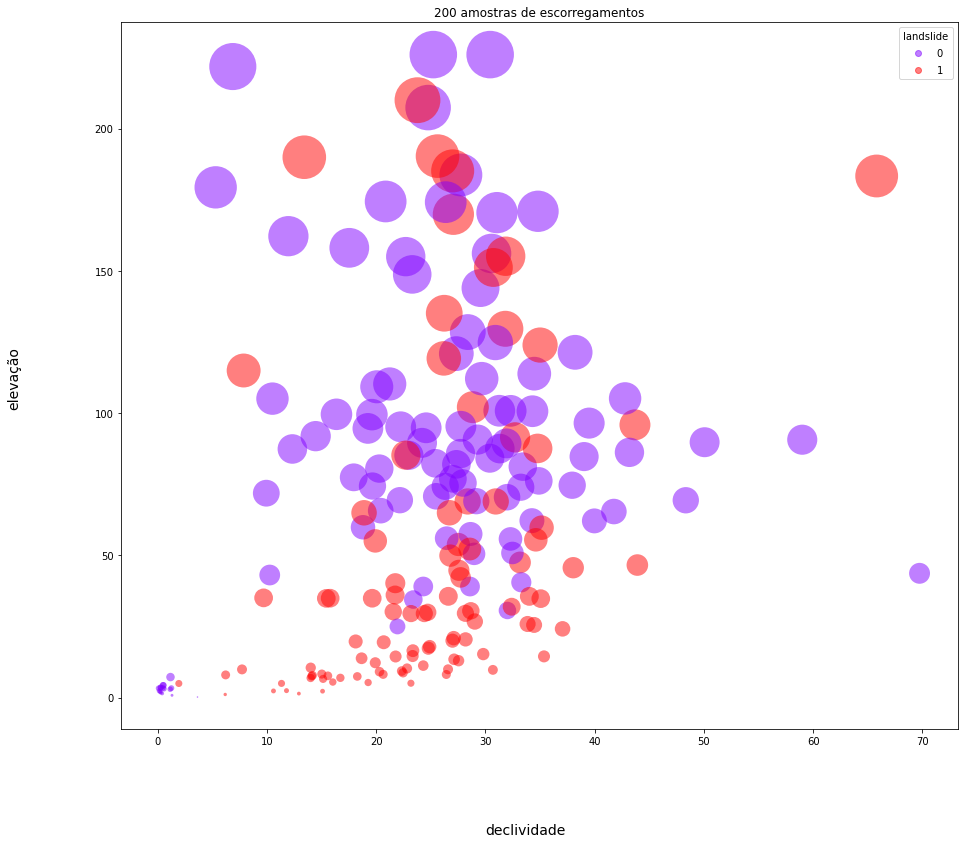

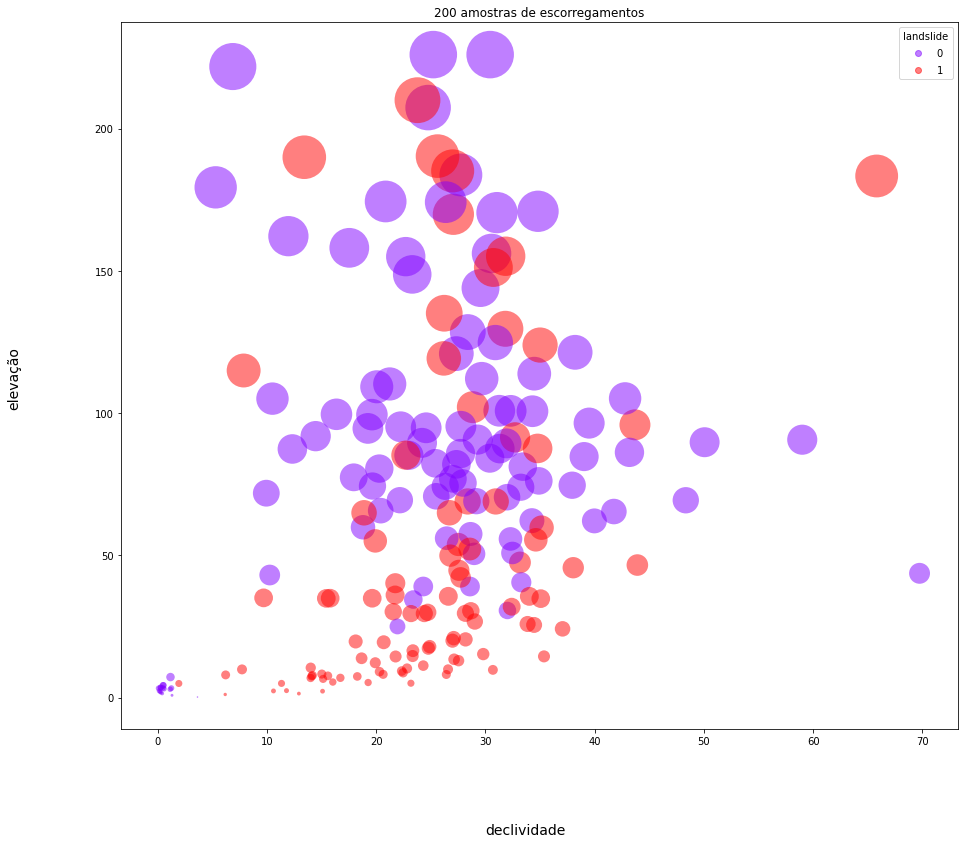

In [180]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' amostras de escorregamentos')) 

# common axis labels
fig.supxlabel('declividade',fontsize=14)
fig.supylabel('elevação',fontsize=14)


plt.show()

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- Data Preparation With k-fold Cross-Validation

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das variáveis, bem como a identificação daquelas que podem ser removidas (vide analise análise da features).__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [181]:
#features menos relevantes guaruja
#dataset = dataset.drop('aspect',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('slope',axis=1)

# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [182]:
def dataSetFullPreparation(dataSet):
    _X = dataset.drop('class',axis=1)
    _y= dataset['class']
    _X = _X.to_numpy()    #converts dataframe into array to be used at NN
    _y = _y.to_numpy()    #converts dataframe into array to be used at NN
    _y = _y.reshape(-1,1) #reorganiza o array em um array 1 x 1

    #normalização do dataset
    minmax = MinMaxScaler(feature_range=(-1, 1))
    _X = minmax.fit_transform(_X.astype(np.float64))
    print(_X.min(axis=0), _X.max(axis=0))
    return _X, _y

In [183]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [184]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)
    
    myTest = test_x

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y, myTest

In [185]:
#divide o dataset em treino-teste-validação
def dataPreparation3(dataSet):
    
    dataSet.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
    dataSet = dataSet[['FID','X','Y','slope','aspect','elevation','uso_solo','lito','twi','curv','class']]

    
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)
    
    myTest = test_x
    
    train_x = train_x[:,3:]
    test_x = test_x[:,3:]
    val_x = val_x[:,3:]
    #test_x = test_x[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
    #val_x = val_x[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
    

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y, myTest

In [186]:
#X_train, X_test, X_val, y_train, y_test, y_val, unSeenDS = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)
X_train, X_test, X_val, y_train, y_test, y_val, unSeenDS = dataPreparation3(dataset_original)

In [187]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')
print(len(unSeenDS), 'test (not scaled) examples')


98 train examples
42 validation examples
60 test examples
60 test (not scaled) examples
98 train examples
42 validation examples
60 test examples
60 test (not scaled) examples


In [188]:
print(X_test.min(axis=0), X_test.max(axis=0))

[-0.99274473 -0.90852314 -1.00818162 -1.         -1.         -0.99274473
 -1.26211285] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]
[-0.99274473 -0.90852314 -1.00818162 -1.         -1.         -0.99274473
 -1.26211285] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [189]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))
X.shape

(200, 7)

(200, 7)

In [190]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))
y.shape

(200, 1)

(200, 1)

In [191]:
features_norm, target_norm = dataSetFullPreparation(dataset)

[-1. -1. -1. -1. -1. -1. -1.] [1. 1. 1. 1. 1. 1. 1.]
[-1. -1. -1. -1. -1. -1. -1.] [1. 1. 1. 1. 1. 1. 1.]


In [192]:
print(len(features_norm), 'amostra completa das features normalizadas')
print(len(target_norm), 'amostra do target')

200 amostra completa das features normalizadas
200 amostra do target
200 amostra completa das features normalizadas
200 amostra do target


## Rede Neural Proprietária

# Avaliação da rede Proprietária

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

__Recupera a melhor configuração de rede da otimização por força bruta__

In [193]:
unSeenDS= np.c_[ unSeenDS, y_test ]
unSeenDS.shape

(60, 11)

(60, 11)

In [194]:
unSeenDS = pd.DataFrame(unSeenDS,columns=['FID','X','Y','slope','aspect','elevation','uso_solo','lito','twi','curv','class'])

In [195]:
unSeenDS.head()

,FID,X,Y,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,70.0,376044.7855,7351156.511,25.230965,319.460205,226.054565,90.0,65.0,25.230965,0.000083,0.0
1,88.0,378944.5845,7354970.978,20.869417,333.448883,174.429718,90.0,65.0,20.869417,0.004144,0.0
2,36.0,373575.4802,7348143.942,19.613224,102.110496,99.502220,90.0,65.0,19.613224,0.010817,0.0
3,144.0,373978.0000,7347581.000,34.021076,91.688049,35.624474,20.0,2.0,4.305001,-0.011586,1.0
4,169.0,377400.0000,7354452.000,22.340815,282.587616,9.369759,90.0,2.0,4.801277,-0.021548,1.0


,FID,X,Y,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,70.0,376044.7855,7351156.511,25.230965,319.460205,226.054565,90.0,65.0,25.230965,0.000083,0.0
1,88.0,378944.5845,7354970.978,20.869417,333.448883,174.429718,90.0,65.0,20.869417,0.004144,0.0
2,36.0,373575.4802,7348143.942,19.613224,102.110496,99.502220,90.0,65.0,19.613224,0.010817,0.0
3,144.0,373978.0000,7347581.000,34.021076,91.688049,35.624474,20.0,2.0,4.305001,-0.011586,1.0
4,169.0,377400.0000,7354452.000,22.340815,282.587616,9.369759,90.0,2.0,4.801277,-0.021548,1.0


In [196]:
bestNN = None 
bestNN = NeuralNetwork.load('bestANN\suscetibilidadeNN-Input_Guaruja_aleatorio_shuffled_98.50.pkl')
#bestNN = NeuralNetwork.load('bestANN\suscetibilidadeNN-Input_Guaruja_200m_shuffled_95.43.pkl')

In [197]:
y_pred = bestNN.predict(X_train)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia Treino: 97.96%
Acurácia Treino: 97.96%


In [198]:
NetworkPerformance(y_train, (y_pred > 0.5))

Accuracy: 0.979592
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392
Cohens kappa: 0.959133
ROC AUC: 0.980769
[[46  0]
 [ 2 50]]
Accuracy: 0.979592
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392
Cohens kappa: 0.959133
ROC AUC: 0.980769
[[46  0]
 [ 2 50]]


Área curva ROC=0.9996
Área curva ROC=0.9996


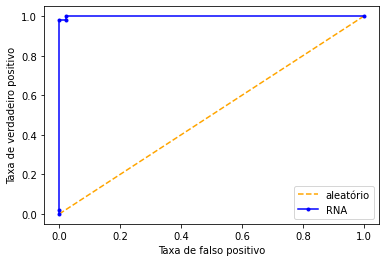

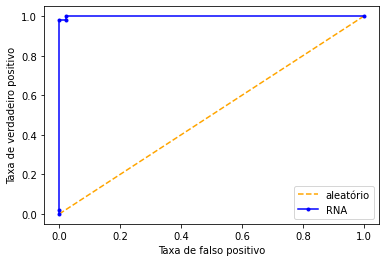

In [199]:
printAUROC(y_train,y_pred)

In [200]:
y_pred = bestNN.predict(X_test)
print('Acurácia Teste: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia Teste: 98.33%
Acurácia Teste: 98.33%


In [201]:
NetworkPerformance(y_test, (y_pred > 0.5))

Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.982759
[[31  0]
 [ 1 28]]
Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.982759
[[31  0]
 [ 1 28]]


Área curva ROC=0.9833
Área curva ROC=0.9833


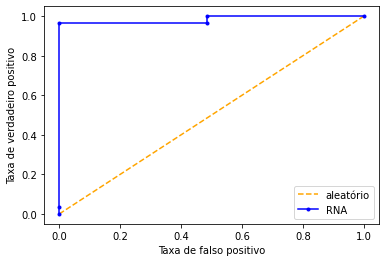

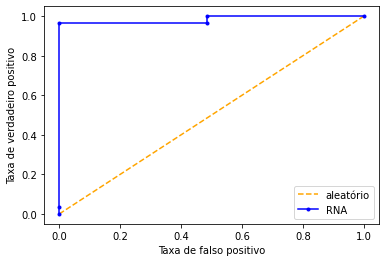

In [202]:
printAUROC(y_test,y_pred)

In [203]:
y_pred = bestNN.predict(X_test)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))
output_proprietario = None
output_proprietario = unSeenDS
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria_unseen.csv', encoding="utf-8")

Acurácia: 98.33%
Acurácia: 98.33%


In [204]:
y_pred = bestNN.predict(X_val)
print('Acurácia Validação: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia Validação: 100.00%
Acurácia Validação: 100.00%


In [205]:
NetworkPerformance(y_val, (y_pred > 0.5))

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


Área curva ROC=1.0000


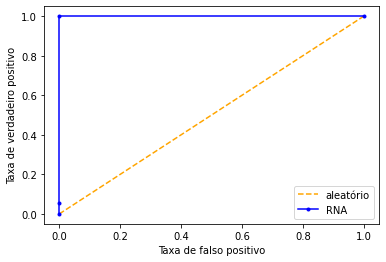

Área curva ROC=1.0000


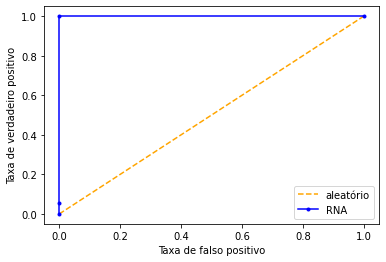

In [206]:
printAUROC(y_val,y_pred)

### validação dataset completo com dados completamente normalizados [considerando treino/test/validação]

In [207]:
y_pred = bestNN.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 98.50%
Acurácia: 98.50%


In [208]:
NetworkPerformance(y, y_pred)

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995400
[[101   0]
 [  3  96]]
Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995400
[[101   0]
 [  3  96]]


In [209]:
tn, fp, fn, tp = confusion_matrix(y,(y_pred > 0.5)).ravel()
(tn, fp, fn, tp)

(101, 0, 3, 96)

(101, 0, 3, 96)

In [210]:
# precision tp / (tp + fp)
precision = precision_score(y,(y_pred > 0.5))
print('Precision: %f' % precision)

Precision: 1.000000
Precision: 1.000000


Área curva ROC=0.9954
Área curva ROC=0.9954


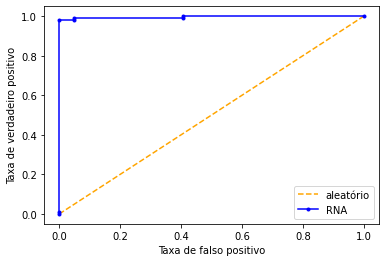

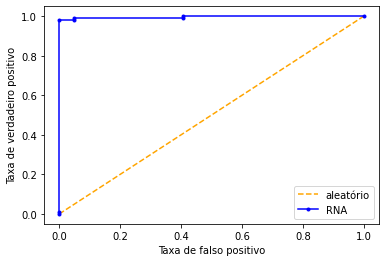

In [211]:
printAUROC(y,y_pred)

### validação dataset completo com dados completamente normalizados [sem considerar treino/test/validação]

In [212]:
features_norm

array([[-0.21755576,  0.83687331,  0.06907513, ...,  1.        ,
        -0.21755576, -0.75916208],
       [-0.29123456, -0.36888357, -0.84798222, ..., -1.        ,
        -0.85464794, -0.75782546],
       [-0.29168303, -0.32272681,  0.83503016, ...,  1.        ,
        -0.29168303, -0.76012998],
       ...,
       [-0.53262633, -0.06568518, -0.11980323, ..., -1.        ,
        -0.53262633, -0.75650451],
       [-0.12863911, -0.13607649,  1.        , ...,  1.        ,
        -0.12863911, -0.7600581 ],
       [-0.27232106,  0.70328112, -0.2723439 , ...,  1.        ,
        -0.27232106, -0.75961052]])

array([[-0.21755576,  0.83687331,  0.06907513, ...,  1.        ,
        -0.21755576, -0.75916208],
       [-0.29123456, -0.36888357, -0.84798222, ..., -1.        ,
        -0.85464794, -0.75782546],
       [-0.29168303, -0.32272681,  0.83503016, ...,  1.        ,
        -0.29168303, -0.76012998],
       ...,
       [-0.53262633, -0.06568518, -0.11980323, ..., -1.        ,
        -0.53262633, -0.75650451],
       [-0.12863911, -0.13607649,  1.        , ...,  1.        ,
        -0.12863911, -0.7600581 ],
       [-0.27232106,  0.70328112, -0.2723439 , ...,  1.        ,
        -0.27232106, -0.75961052]])

In [213]:
y_pred = bestNN.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 98.50%
Acurácia: 98.50%


In [214]:
NetworkPerformance(y, (y_pred > 0.5))

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.984848
[[101   0]
 [  3  96]]
Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.984848
[[101   0]
 [  3  96]]


Área curva ROC=0.9954
Área curva ROC=0.9954


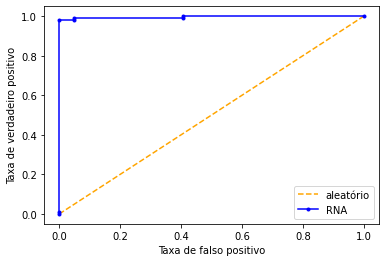

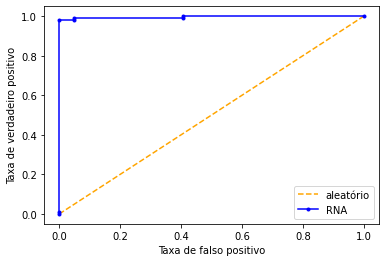

In [215]:
printAUROC(y,y_pred)

In [216]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

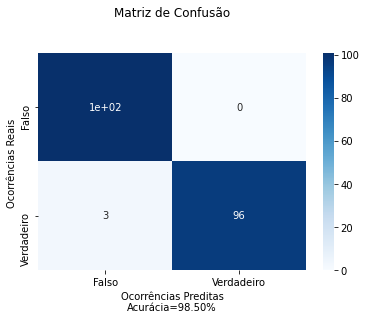

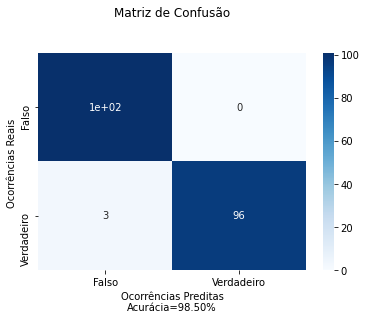

In [217]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de Confusão\n\n')
ax.set_xlabel('Ocorrências Preditas\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Ocorrências Reais ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [218]:
tn, fp, fn, tp = confusion_matrix(y,(y_pred > 0.5)).ravel()
(tn, fp, fn, tp)

(101, 0, 3, 96)

(101, 0, 3, 96)

In [219]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred

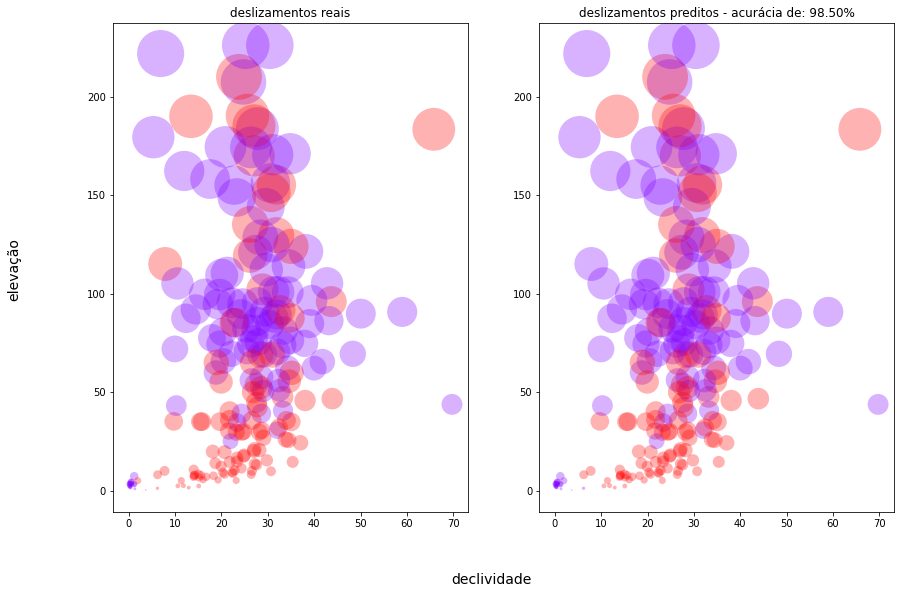

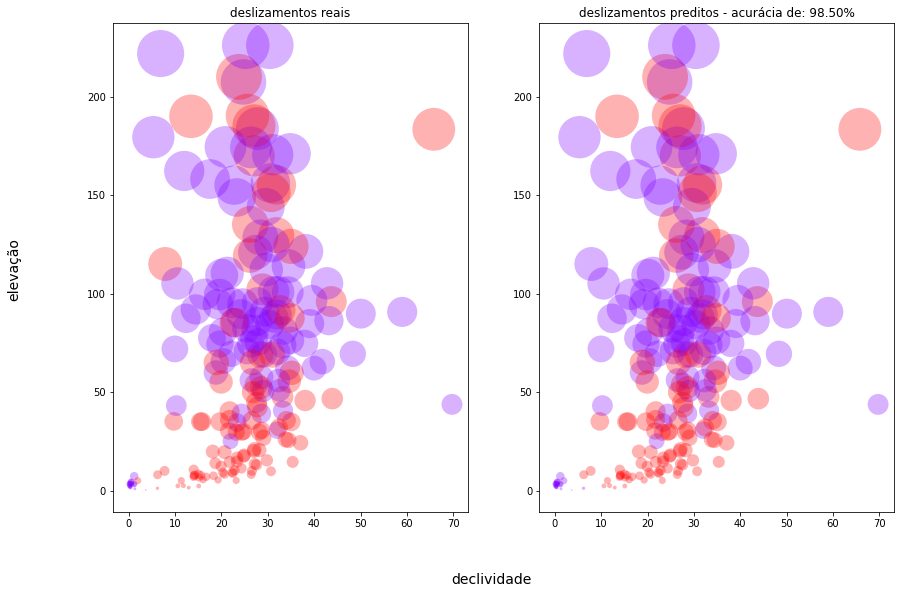

In [220]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

#fig.tight_layout()
text = 'deslizamentos preditos -' + ' acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

# common axis labels
fig.supxlabel('declividade',fontsize=14)
fig.supylabel('elevação',fontsize=14)


plt.show()

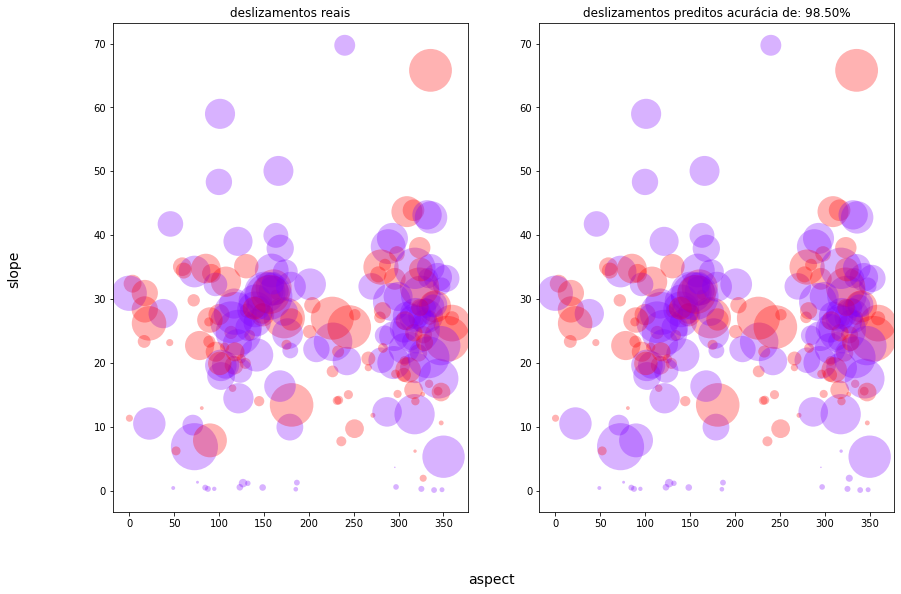

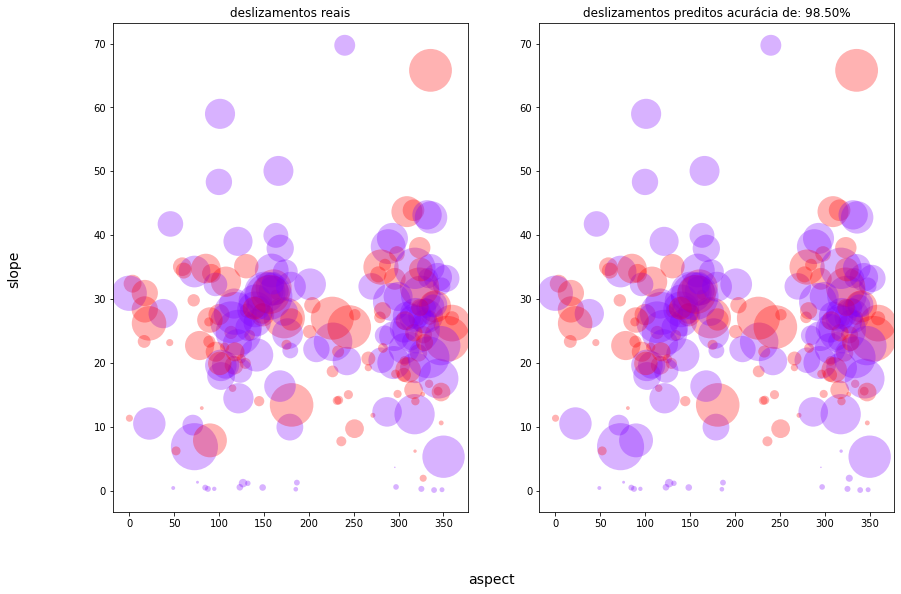

In [221]:
#TWI	Curvatura	Declividade	Elevacao	Aspecto	Geologia	Uso	class
#aleatorio -  Elevacao x TWI ou Declividade x TWI ou TWI x Aspecto
#200m - slope x twi
eixo_x = 'aspect' #Declividade
eixo_y = 'slope'

sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario[eixo_x], output_proprietario[eixo_y],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario[eixo_x], output_proprietario[eixo_y],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

#fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

# common axis labels
fig.supxlabel('aspect',fontsize=14)
fig.supylabel('slope',fontsize=14)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [222]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [223]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
Numero de Splits_stratified de X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [224]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [97.5, 100.0, 97.5, 100.0, 97.5, 100.0, 95.0, 100.0, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 98.5 %

Desvio Padrão: 1.7480147469502525
Lista de acurácias obtidas: [97.5, 100.0, 97.5, 100.0, 97.5, 100.0, 95.0, 100.0, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 98.5 %

Desvio Padrão: 1.7480147469502525


In [225]:
dataset

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


__Geração do arquivo de saída__

In [226]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 98.50%
Acurácia: 98.50%


In [227]:
NetworkPerformance(y, (y_pred))

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995400
[[101   0]
 [  3  96]]
Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.995400
[[101   0]
 [  3  96]]


Área curva ROC=0.9954
Área curva ROC=0.9954


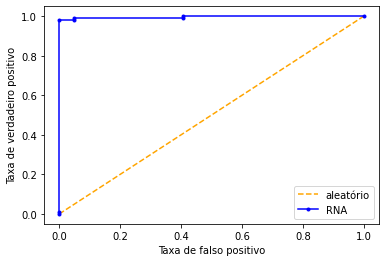

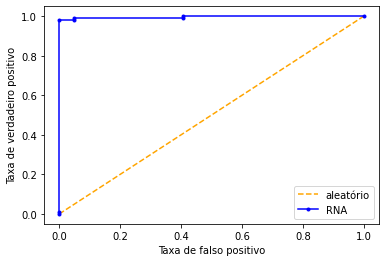

In [228]:
printAUROC(y,y_pred)

In [229]:
output_proprietario

,FID,X,Y,twi,curv,slope,elevation,aspect,lito,uso_solo,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.003674
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.997674
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000929
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.999309
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.239259
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000419
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.015829
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000189


,FID,X,Y,twi,curv,slope,elevation,aspect,lito,uso_solo,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.003674
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.997674
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000929
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.999309
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.239259
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000419
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.015829
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000189


- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

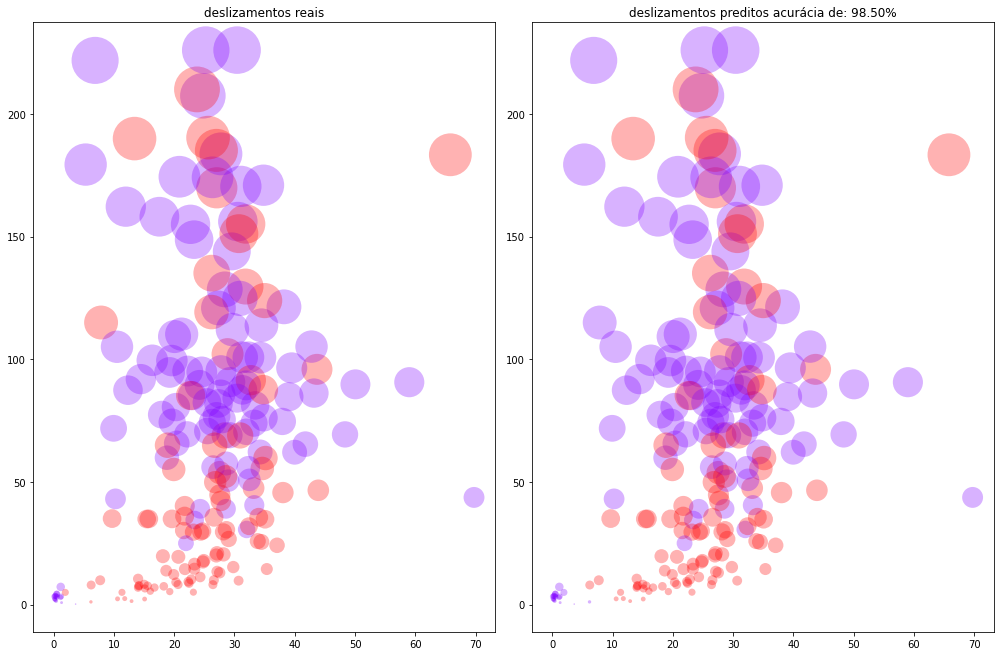

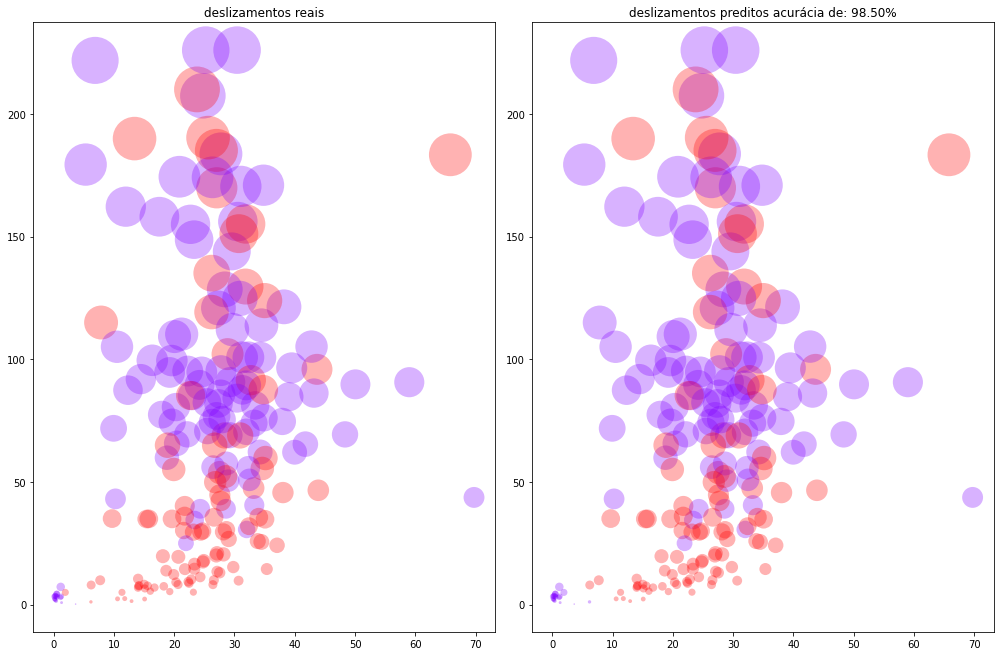

In [230]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


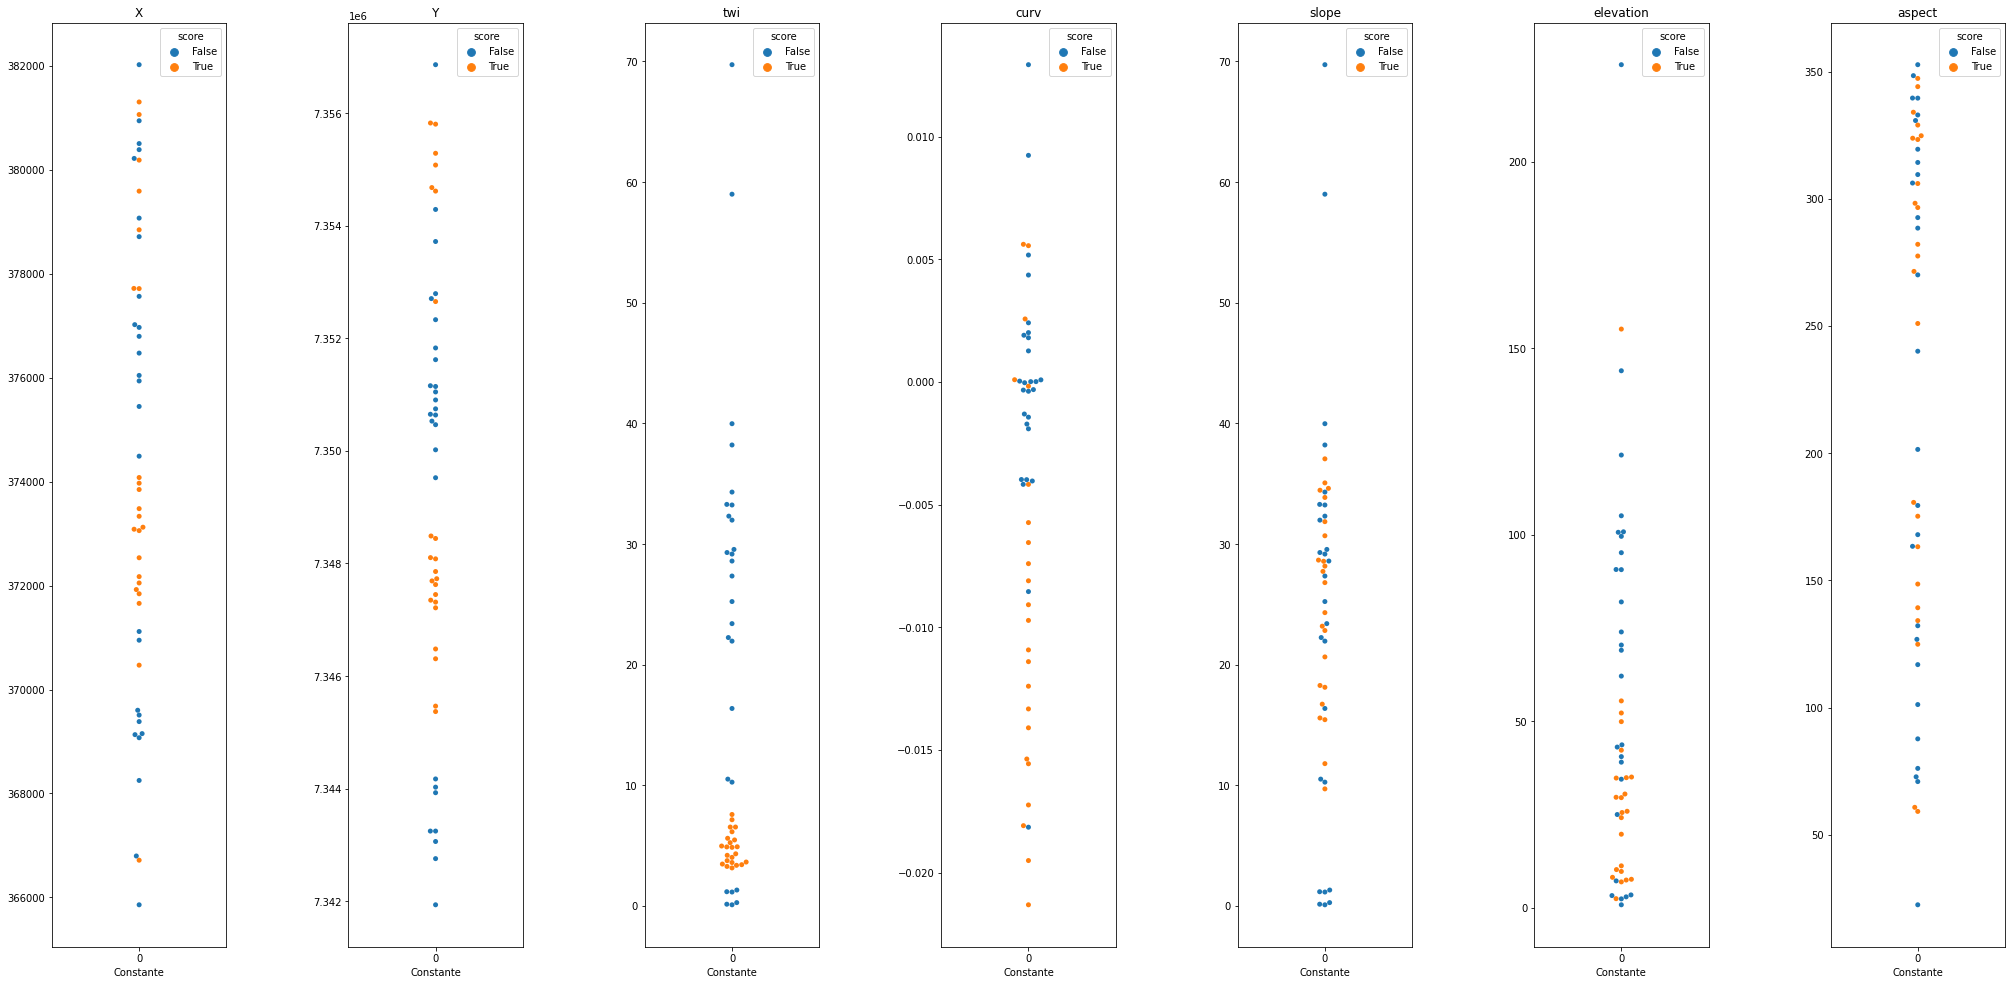

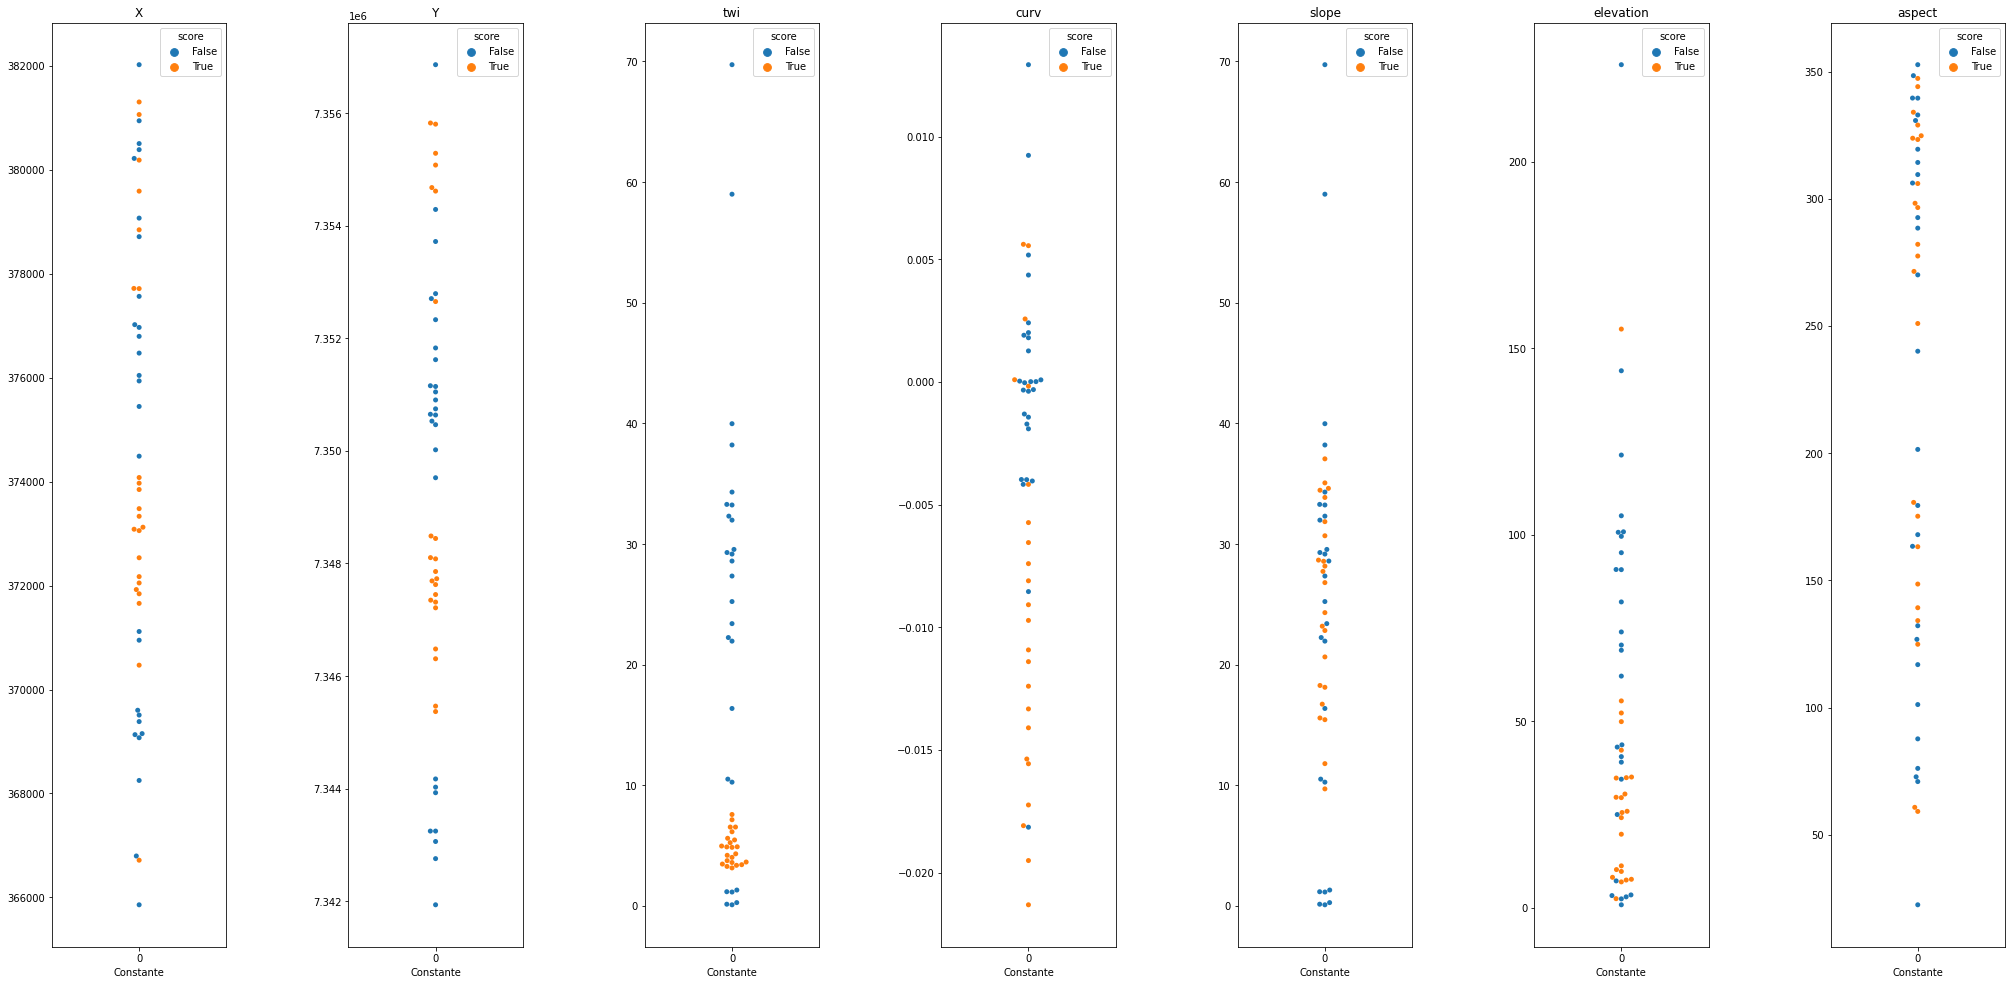

In [231]:
dataSet = output_proprietario.sample(n = 50)
dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [232]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

## Rede Neural  Keras
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


In [233]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [234]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples
98 train examples
42 validation examples
60 test examples


__Recupera a melhor configuração de rede keras da otimização por força bruta (Keras tuner)__

In [235]:
hypermodel = keras.models.load_model('bestANN\suscetibilidadeKeras_guaruja.pkl')

In [236]:
  # avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9667
Accuracy: 96.67
2/2 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9667
Accuracy: 96.67


In [237]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

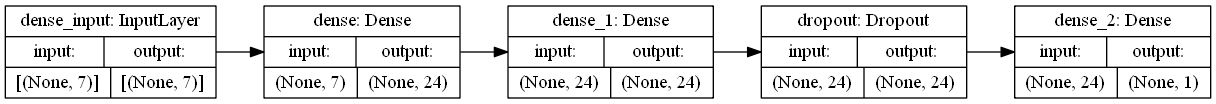

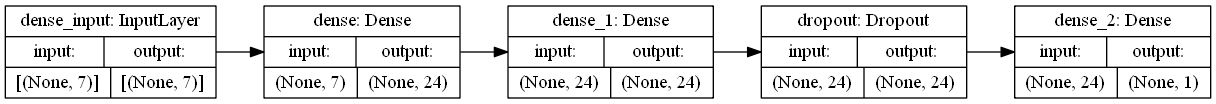

In [238]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")  

# Avaliação da rede keras otimizada

In [239]:
y_pred = hypermodel.predict(X_train)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia Treino: 98.98%
Acurácia Treino: 98.98%


In [240]:
NetworkPerformance(y_train, (y_pred > 0.5))

Accuracy: 0.989796
Precision: 1.000000
Recall: 0.980769
F1 score: 0.990291
Cohens kappa: 0.979541
ROC AUC: 0.990385
[[46  0]
 [ 1 51]]
Accuracy: 0.989796
Precision: 1.000000
Recall: 0.980769
F1 score: 0.990291
Cohens kappa: 0.979541
ROC AUC: 0.990385
[[46  0]
 [ 1 51]]


Área curva ROC=1.0000
Área curva ROC=1.0000


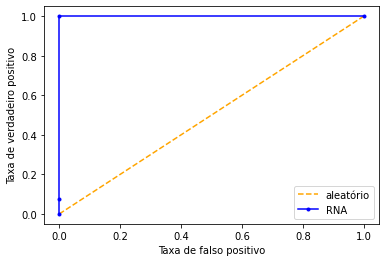

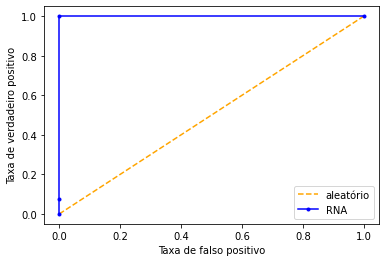

In [241]:
printAUROC(y_train,y_pred)

In [242]:
y_pred = hypermodel.predict(X_test)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia Treino: 96.67%
Acurácia Treino: 96.67%


In [243]:
NetworkPerformance(y_test, (y_pred > 0.5))

Accuracy: 0.966667
Precision: 0.965517
Recall: 0.965517
F1 score: 0.965517
Cohens kappa: 0.933259
ROC AUC: 0.966630
[[30  1]
 [ 1 28]]
Accuracy: 0.966667
Precision: 0.965517
Recall: 0.965517
F1 score: 0.965517
Cohens kappa: 0.933259
ROC AUC: 0.966630
[[30  1]
 [ 1 28]]


Área curva ROC=0.9855
Área curva ROC=0.9855


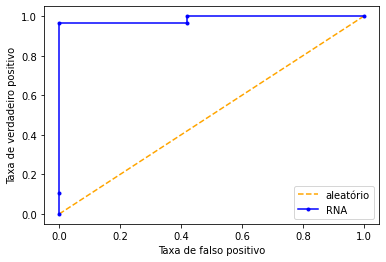

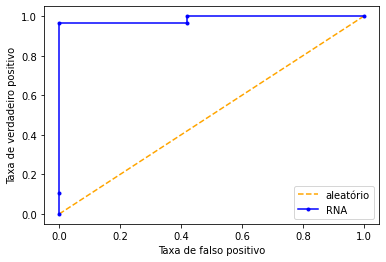

In [244]:
printAUROC(y_test,y_pred)

In [245]:
y_pred = hypermodel.predict(X_val)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia Treino: 100.00%
Acurácia Treino: 100.00%


In [246]:
NetworkPerformance(y_val, (y_pred > 0.5))

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


Área curva ROC=1.0000
Área curva ROC=1.0000


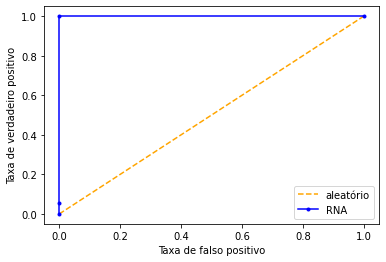

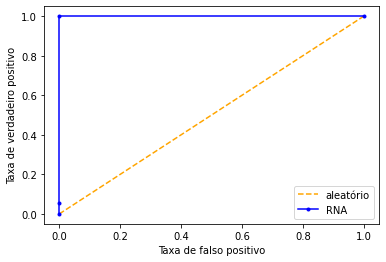

In [247]:
printAUROC(y_val,y_pred)

In [248]:
y_pred = hypermodel.predict(features_norm)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(target_norm, y_pred > 0.5)))

Acurácia: 97.00%
Acurácia: 97.00%


In [249]:
NetworkPerformance(target_norm, (y_pred > 0.5))

Accuracy: 0.970000
Precision: 0.969697
Recall: 0.969697
F1 score: 0.969697
Cohens kappa: 0.939994
ROC AUC: 0.969997
[[98  3]
 [ 3 96]]
Accuracy: 0.970000
Precision: 0.969697
Recall: 0.969697
F1 score: 0.969697
Cohens kappa: 0.939994
ROC AUC: 0.969997
[[98  3]
 [ 3 96]]


Área curva ROC=0.9936
Área curva ROC=0.9936


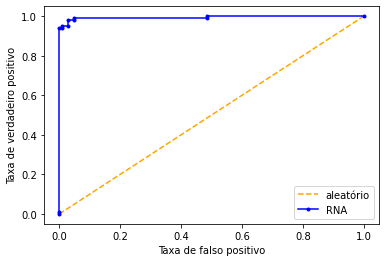

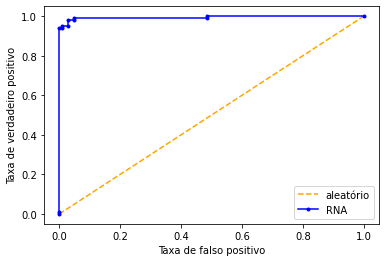

In [250]:
printAUROC(target_norm,y_pred)

In [251]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,random_state=36851234)

print ('Número de Splits de X: ',rskf.get_n_splits(features_norm, target_norm),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(features_norm, target_norm): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    features_norm_train, features_norm_test = features_norm[train_index], features_norm[test_index]
    target_norm_train, target_norm_test = target_norm[train_index], target_norm[test_index]
    #print(X_train.shape, y_train.shape)
    
    yhat_probs = hypermodel.predict(features_norm_test)
    lst_accu_stratified.append(100*accuracy_score(target_norm_test, yhat_probs > 0.5))

Número de Splits de X:  20 

Número de Splits de X:  20 



In [252]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [100.0, 95.0, 95.0, 95.0, 100.0, 90.0, 100.0, 100.0, 100.0, 95.0, 95.0, 100.0, 100.0, 90.0, 100.0, 100.0, 95.0, 95.0, 100.0, 95.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 90.0 %

Acurácia média: 97.0 %

Desvio Padrão: 3.4027852368936027
Lista de acurácias obtidas: [100.0, 95.0, 95.0, 95.0, 100.0, 90.0, 100.0, 100.0, 100.0, 95.0, 95.0, 100.0, 100.0, 90.0, 100.0, 100.0, 95.0, 95.0, 100.0, 95.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 90.0 %

Acurácia média: 97.0 %

Desvio Padrão: 3.4027852368936027


__Geração arquivo de saída__

In [253]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,FID,X,Y,twi,curv,slope,elevation,aspect,lito,uso_solo,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000508
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.998192
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.004502
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.999640
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.017049
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.003419
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.013313
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000429


,FID,X,Y,twi,curv,slope,elevation,aspect,lito,uso_solo,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000508
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.998192
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.004502
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.999640
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.017049
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.003419
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.013313
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000429


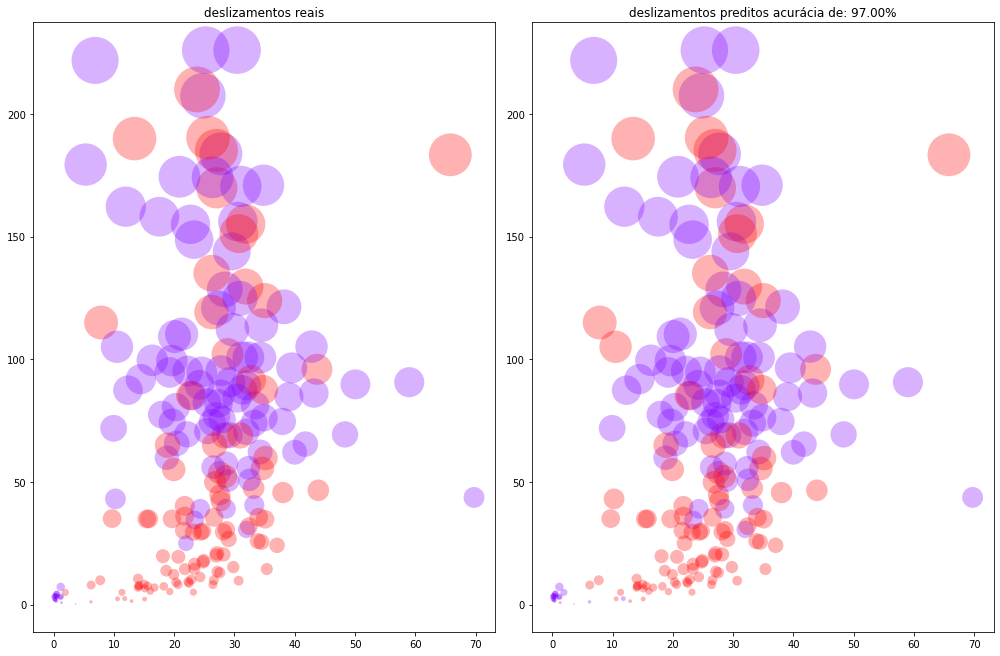

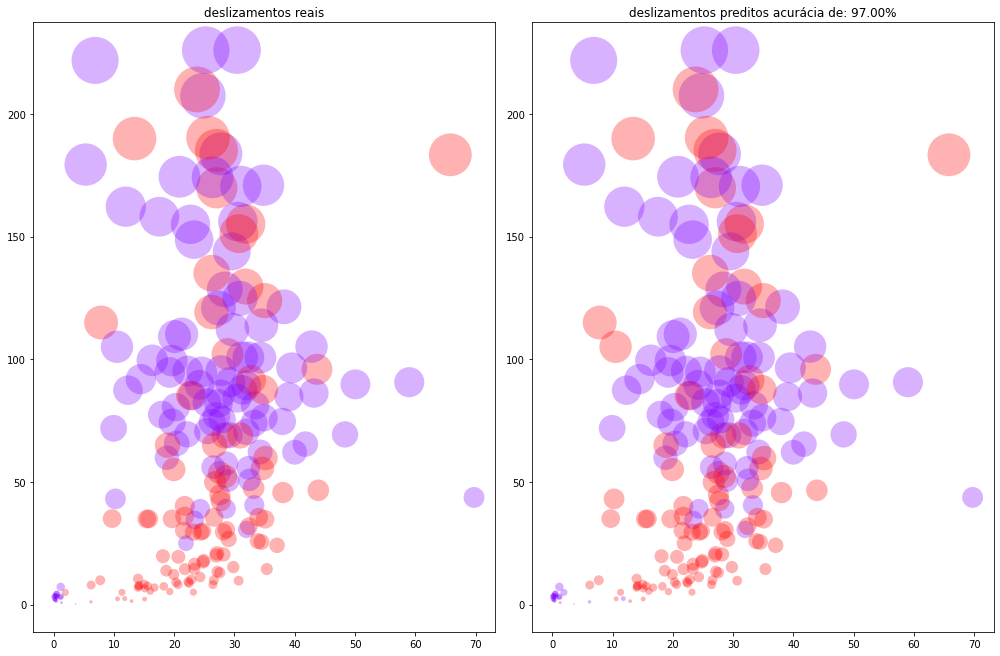

In [254]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.

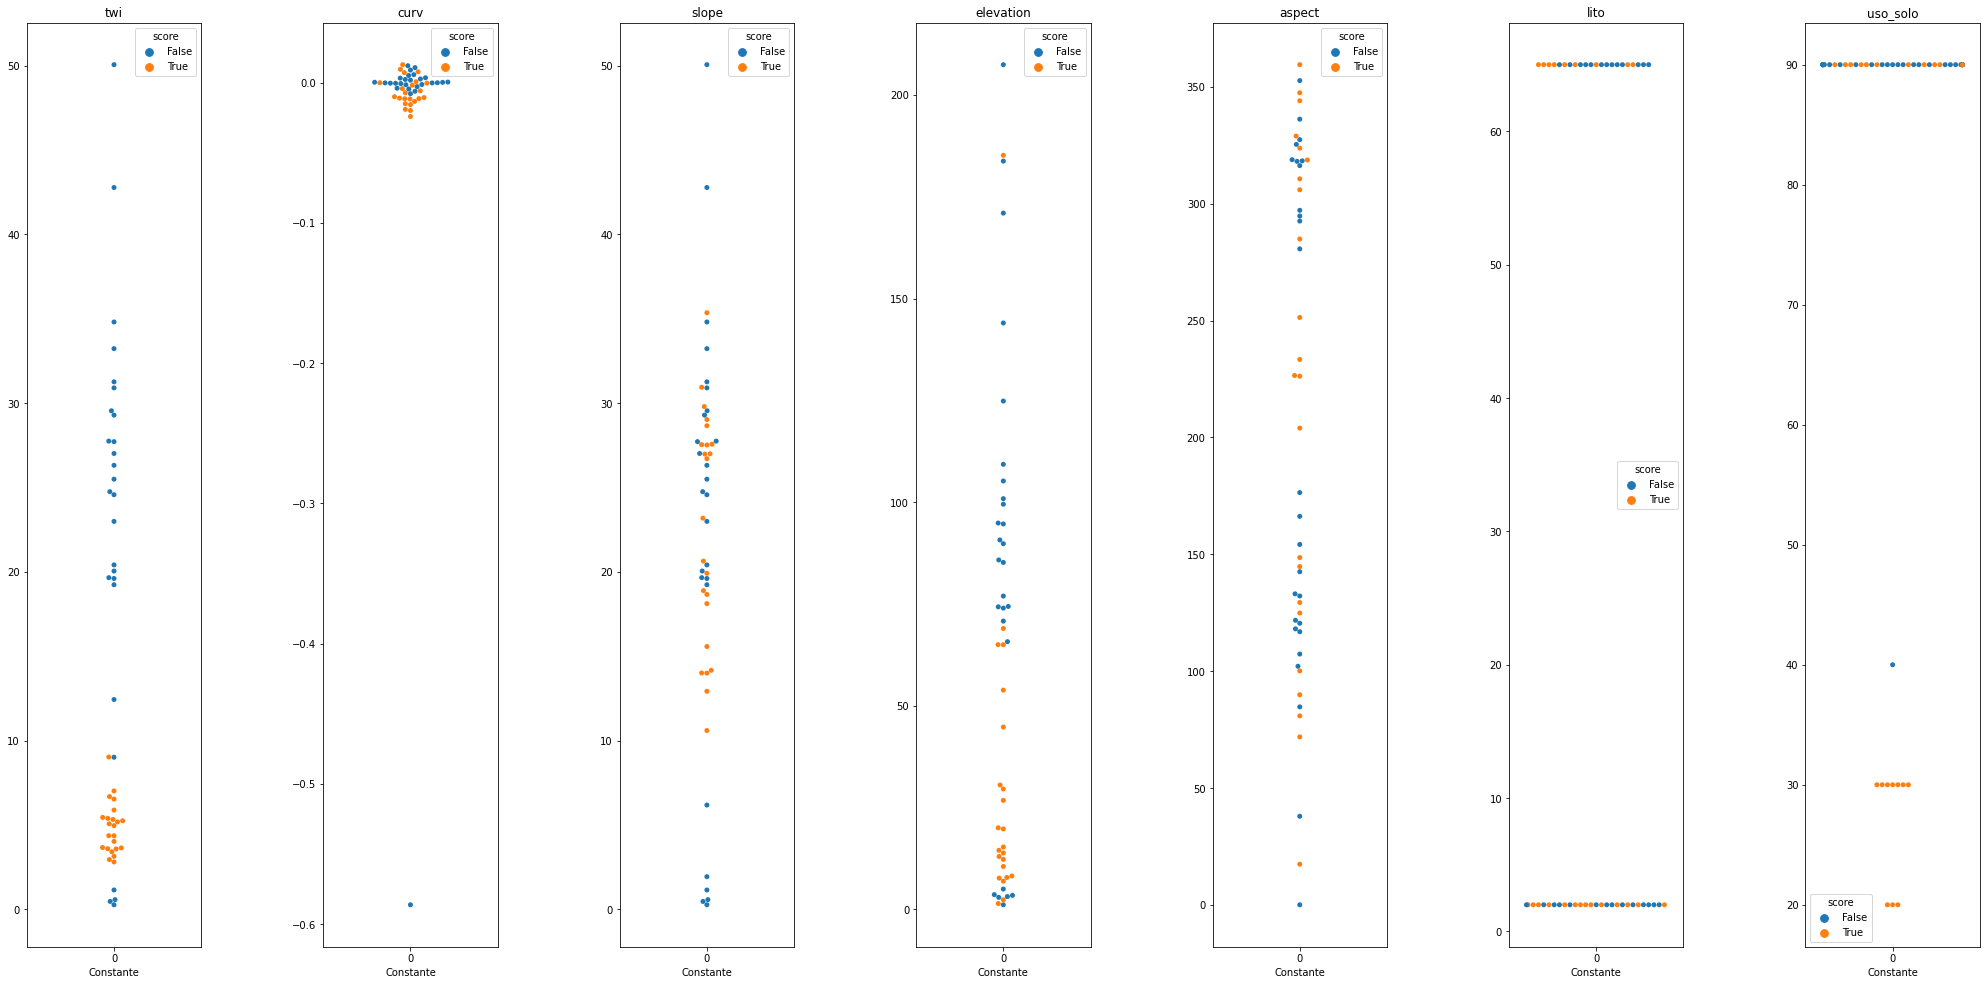

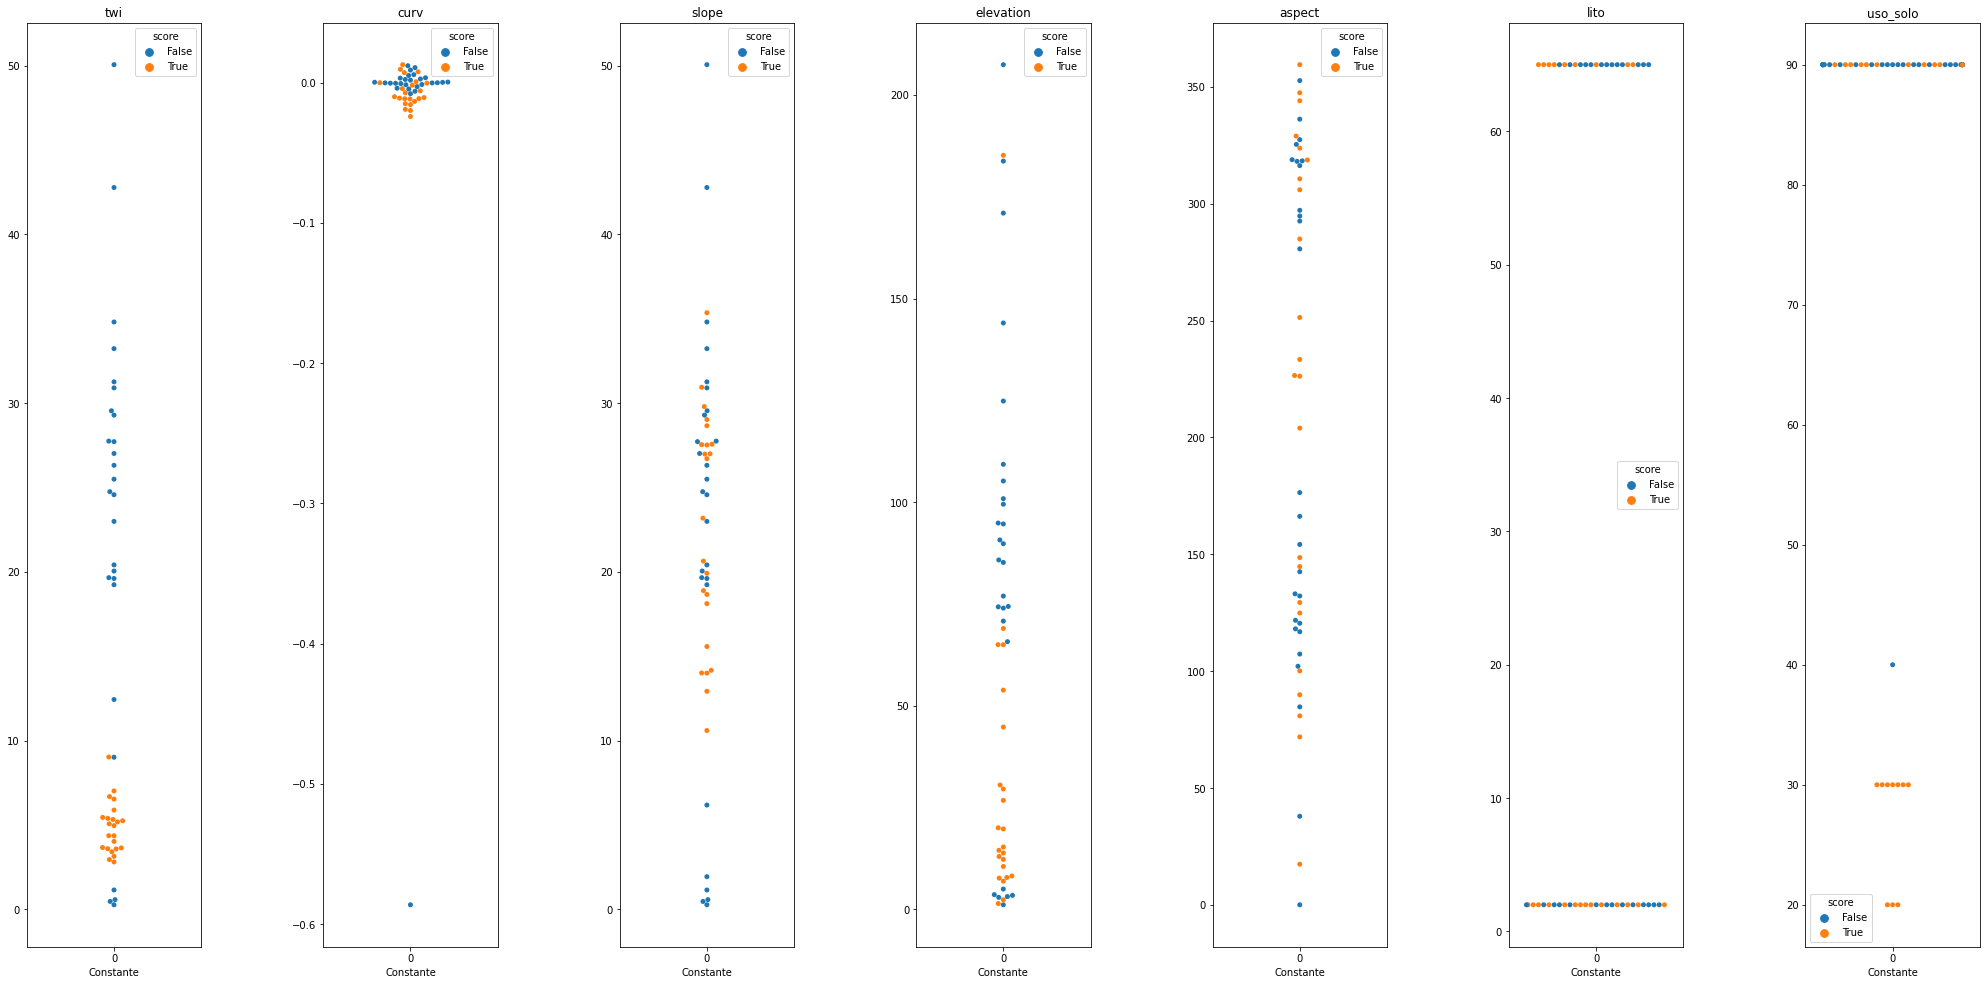

In [255]:
dataSet = output_keras.sample(n = 50)
dataSet = dataSet.drop('FID',axis=1)
dataSet = dataSet.drop('X',axis=1)
dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)